### **Descarga e importe de bibliotecas**

In [1]:
%%capture
!pip install git+https://github.com/qubvel/classification_models.git

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [3]:
import gc
import re
import glob
import random
import shutil
import zipfile
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
import tf_keras.backend as K
from tf_keras.losses import Loss
from tf_keras.layers import Layer
from tf_keras import layers, Model
from tf_keras.optimizers import Adam
from tf_keras.callbacks import Callback
from tf_keras.saving import register_keras_serializable

# ResUNet Model Backbone
from classification_models.tfkeras import Classifiers  # Requires: pip install git+https://github.com/qubvel/classification_models.git

### **Configuración del entorno**

In [4]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [5]:
# Create a distribution strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


### **Descarga y cargado de la base de datos de semillas**

##### **Importante definir el número de clases**

In [6]:
classes = 2 # Puede ser 3 para tres clases; 0-Fondo, 1-Semilla germinada, 2-Semilla no germinada, o 2 para dos clases; 0-Fondo, 1-Semilla

In [7]:
# Download histology dataset
classes_ = {3:1, 2:2}
!kaggle datasets download lucasiturriago/seeds/{classes_[classes]}

os.makedirs('./datasets/Seeds', exist_ok=True)
with zipfile.ZipFile('./seeds.zip', 'r') as zip_ref: zip_ref.extractall('./datasets/Seeds')
!rm -rf ./seeds.zip

Dataset URL: https://www.kaggle.com/datasets/lucasiturriago/seeds/versions/2
License(s): CC-BY-SA-4.0
 98%|███████████████████████████████████████▉ | 973M/998M [00:04<00:00, 247MB/s]
100%|█████████████████████████████████████████| 998M/998M [00:04<00:00, 215MB/s]


In [8]:
config = {"Seg_model":"VGG16UNet","Activation":"softmax","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"SeedsDA","Dir of dataset":"./datasets/Seeds","Batch size":32,"Epochs":60,"Number of classes":classes}

In [9]:
class DataLoader:

    def __init__(self, data_dir, batch_size, image_size, num_classes, partition):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition

    def load_images(self):

        # Create the path for patch images
        images_path_pattern = os.path.join(self.data_dir, self.partition, 'images', '*.png')
        images_files = glob.glob(images_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        images_files = sorted(images_files, key=alphanumeric_key)

        self.file_sample = []
        for file in images_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(images_files)

        # Print the complete path and the number of found patch images
        print(f"Complete images: {images_path_pattern}")
        print(f"Number of images files found: {len(images_files)}")

        # Create a TensorFlow dataset from the images file paths
        images_ds = tf.data.Dataset.from_tensor_slices(images_files)

        # Map each file path to a processed image
        images_ds = images_ds.map(self.process_images, num_parallel_calls=tf.data.AUTOTUNE)

        return images_ds

    def load_masks(self):

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Check samples in classes
        for class_id in range(self.num_classes):
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        masks_path = []
        # Organize ground truth masks by sample and class
        for sample in self.file_sample:
            masks_sample = []
            for class_id in range(self.num_classes):
                masks_sample.append(os.path.join(mask_path_main, f'class_{class_id}', sample))
            masks_path.append(masks_sample)

        # Create dataset from `masks_path` and apply `process_masks` to each set of paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_path)
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_images(self, file_path):

        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode PNG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img = tf.cast(img, tf.float32)  # Convert to float32
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, sample_paths):

        # Decode and process images
        decoded_images = tf.map_fn(
            tf.io.read_file,
            sample_paths,
            dtype=tf.string,
            parallel_iterations=4
        )

        masks = tf.map_fn(
            lambda x: tf.io.decode_png(x, channels=1),
            decoded_images,
            dtype=tf.uint8,
            parallel_iterations=4
        )

        # Resize and normalize
        masks = tf.map_fn(
            lambda x: tf.image.resize(x, size=self.image_size),
            masks,
            dtype=tf.float32
        )

        masks = tf.cast(masks, tf.float32)  # Convert to float32
        masks = masks / 255.0  # Normalize to [0, 1]
        masks = tf.squeeze(masks, axis=-1)  # Remove the last dimension
        masks = tf.transpose(masks, perm=[1, 2, 0])  # Transpose to [height, width, classes]

        return masks

    def get_dataset(self):

        images_ds = self.load_images()
        masks_ds = self.load_masks()
        dataset = tf.data.Dataset.zip((images_ds,masks_ds))

        # Apply batching and prefetching for optimization
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [10]:
# Instantiate data loader and load train partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Train')
train_dataset = data_loader.get_dataset()

Complete images: ./datasets/Seeds/Train/images/*.png
Number of images files found: 2458
Original masks path, class 0: ./datasets/Seeds/Train/masks/class_0/*.png
Number of masks found: 2458
Original masks path, class 1: ./datasets/Seeds/Train/masks/class_1/*.png
Number of masks found: 2458


In [11]:
# Instantiate data loader and load validation partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Valid')
valid_dataset = data_loader.get_dataset()

Complete images: ./datasets/Seeds/Valid/images/*.png
Number of images files found: 231
Original masks path, class 0: ./datasets/Seeds/Valid/masks/class_0/*.png
Number of masks found: 231
Original masks path, class 1: ./datasets/Seeds/Valid/masks/class_1/*.png
Number of masks found: 231


In [12]:
# Instantiate data loader and load test partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Test')
test_dataset = data_loader.get_dataset()

Complete images: ./datasets/Seeds/Test/images/*.png
Number of images files found: 118
Original masks path, class 0: ./datasets/Seeds/Test/masks/class_0/*.png
Number of masks found: 118
Original masks path, class 1: ./datasets/Seeds/Test/masks/class_1/*.png
Number of masks found: 118


#### **Visualización de la base de datos de semillas**

In [13]:
def random_sample_visualization(dataset, num_classes):

    # Select first batch
    batch = 0

    # Skip to the desired batch and take one batch
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    # Determine the number of columns for the visualization grid
    columns = []
    rows = 2

    columns.append(masks.shape[-1] if masks.shape[-1] <= 6 else 6)

    columns = max(columns)

    fig = plt.figure(figsize=(20, 12))
    
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample])  # Show the sample image

    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Masks of segmentation for different classes",loc='left')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(num_classes,columns):
        num = random.randint(0, num_classes-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-1][i].imshow(masks[sample, :, :, classes_list[i]:classes_list[i]+1])

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()

    # Free memory
    del images, masks # Delete large variables
    if 'annotators_list' in locals():
        del annotators_list
    if 'classes_list' in locals():
        del classes_list
    gc.collect() # Force garbage collection

Images in the batch: (32, 512, 512, 3), Masks in the batch: (32, 512, 512, 2)


<ipython-input-13-bf66a0e7f52d>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


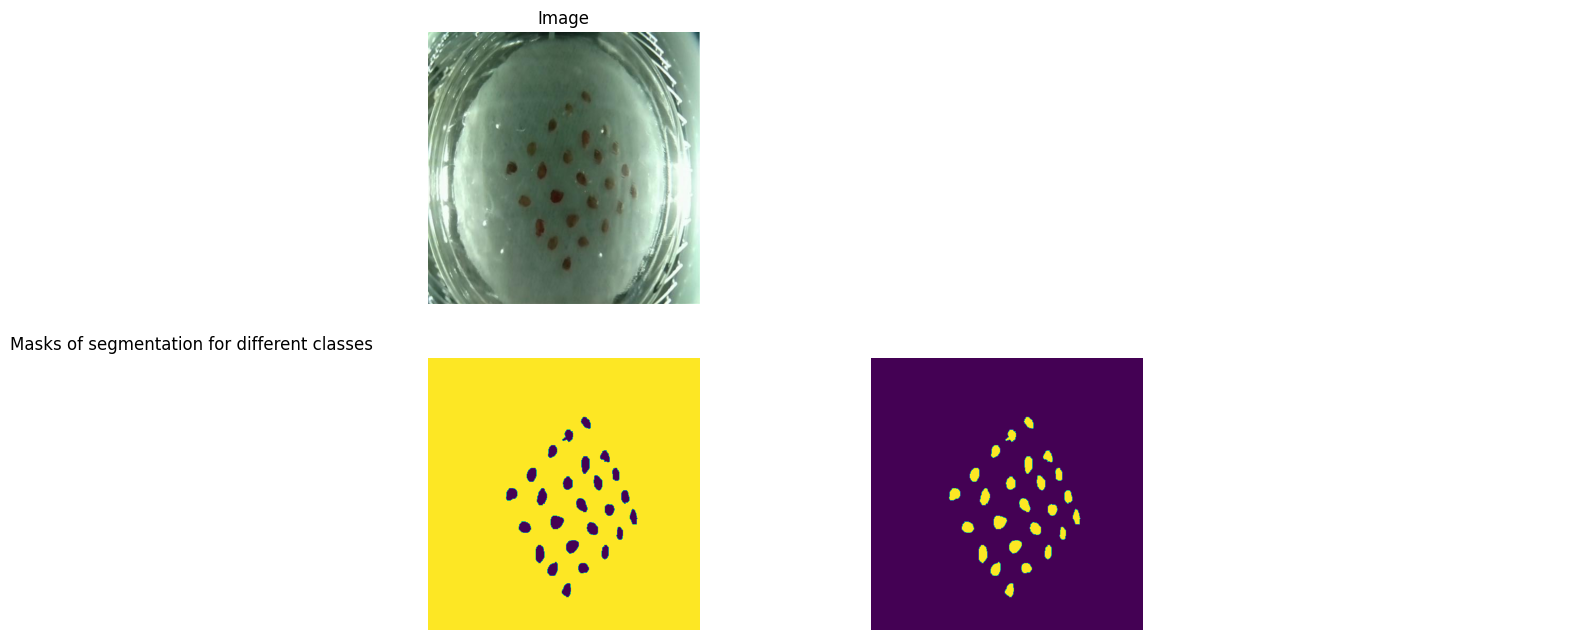

In [14]:
random_sample_visualization(train_dataset, config['Number of classes'])

### **Definición y creación del modelo, medidas de rendimiento y función de pérdida**

In [15]:
pip install git+https://github.com/UN-GCPDS/seeds_segmentation.git --quiet

  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [16]:
from seeds_segmentation import unet_vgg16
from seeds_segmentation.losses import DiceCoefficient 

@register_keras_serializable(package="my_custom_metrics")
def dice_metric(y_true, y_pred, smooth=1e-7, axis=(1, 2), return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)

    if return_mean:
        return tf.reduce_mean(dice)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if dice.shape[1] > 1:
            return tf.transpose(dice, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(dice, perm=[1, 0]), axis=0)
            
@register_keras_serializable(package="my_custom_metrics")
def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    if return_mean:
        return tf.reduce_mean(jaccard)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if jaccard.shape[1] > 1:
            return tf.transpose(jaccard, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(jaccard, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + smooth)
    if return_mean:
        return tf.reduce_mean(sensitivity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if sensitivity.shape[1] > 1:
            return tf.transpose(sensitivity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(sensitivity, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + tf.keras.backend.epsilon())
    if return_mean:
        return tf.reduce_mean(specificity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if specificity.shape[1] > 1:
            return tf.transpose(specificity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(specificity, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def precision_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)

    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred, axis=axis)
    
    precision = true_positives / (true_positives + false_positives + smooth)

    if return_mean:
        return tf.reduce_mean(precision)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if precision.shape[1] > 1:
            return tf.transpose(precision, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(precision, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def recall_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)

    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred), axis=axis)
    
    recall = true_positives / (true_positives + false_negatives + smooth)

    if return_mean:
        return tf.reduce_mean(recall)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if recall.shape[1] > 1:
            return tf.transpose(recall, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(recall, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def mean_average_precision(y_true, y_pred, axis=(1, 2), smooth=1e-7, thresholds=None, return_mean=True):
    if thresholds is None:
        thresholds = tf.linspace(0.5, 0.95, 10)
    
    iou = jaccard_metric(y_true, y_pred, axis=axis, smooth=smooth, return_mean=False)  # (batch, classes)

    # Expandimos dimensiones para broadcasting
    thresholds = tf.reshape(thresholds, (-1, 1, 1))  # (T, 1, 1)
    iou = tf.expand_dims(iou, axis=0)               # (1, batch, classes)
    
    # Comparar IoU con umbrales en paralelo usando broadcasting
    aps = tf.reduce_mean(tf.cast(iou > thresholds, tf.float32), axis=1)  # (T, classes)
    
    mAP = tf.reduce_mean(aps, axis=0)  # Promedio de umbrales (classes,)

    return tf.reduce_mean(mAP) if return_mean else mAP
    
@register_keras_serializable(package="my_custom_activations")
def sparse_softmax(x):
    
    e_x = tf.exp(x - tf.reduce_max(x, axis=-1, keepdims=True))
    sum_e_x = tf.reduce_sum(e_x, axis=-1, keepdims=True)
    output = e_x / (sum_e_x + keras.backend.epsilon())
    return output

In [17]:
with strategy.scope():
    model = unet_vgg16(input_shape=config['Input size'], out_channels=config['Number of classes'], out_ActFunction=config['Activation'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=DiceCoefficient(smooth=1e-7, target_class=None if config['Number of classes'] == 3 else 1),
                  metrics=[dice_metric,jaccard_metric,sensitivity_metric,specificity_metric, precision_metric, recall_metric, mean_average_precision])

58889256/58889256 [==============================] - 0s 0us/step


### **Entrenamiento de la base de datos**

In [18]:
class CustomLearningRateScheduler(Callback):
    def __init__(self, new_lr, epoch_to_change):
        super(CustomLearningRateScheduler, self).__init__()
        self.new_lr = new_lr
        self.epoch_to_change = epoch_to_change

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.epoch_to_change:
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.new_lr)
            print(f"Learning rate changed to {self.new_lr} at epoch {epoch}")

lr_scheduler = CustomLearningRateScheduler(1e-5, 30)
history = model.fit(train_dataset, epochs=config['Epochs'], validation_data=(valid_dataset), callbacks=[lr_scheduler])

Epoch 1/60
77/77 [==============================] - 141s 2s/step - loss: -0.1212 - dice_metric: 0.4012 - jaccard_metric: 0.2970 - sensitivity_metric: 0.6326 - specificity_metric: 0.6326 - precision_metric: 0.5248 - recall_metric: 0.6326 - mean_average_precision: 0.1032 - val_loss: -0.1808 - val_dice_metric: 0.5159 - val_jaccard_metric: 0.4145 - val_sensitivity_metric: 0.7919 - val_specificity_metric: 0.7919 - val_precision_metric: 0.5533 - val_recall_metric: 0.7919 - val_mean_average_precision: 0.2445
Epoch 2/60
77/77 [==============================] - 116s 2s/step - loss: -0.5689 - dice_metric: 0.7982 - jaccard_metric: 0.7216 - sensitivity_metric: 0.8310 - specificity_metric: 0.8310 - precision_metric: 0.8315 - recall_metric: 0.8310 - mean_average_precision: 0.5825 - val_loss: -0.7718 - val_dice_metric: 0.9100 - val_jaccard_metric: 0.8531 - val_sensitivity_metric: 0.8944 - val_specificity_metric: 0.8944 - val_precision_metric: 0.9403 - val_recall_metric: 0.8944 - val_mean_average_prec

In [19]:
model.save(f"{config['Seg_model']}_{config['Activation']}_{config['Dataset']}.keras")

### **Desempeño del modelo**

#### **Visualización de las inferencias del modelo**

In [20]:
def performance_visualization(dataset, model, config):

    # Select a random batch index
    batch = 0

    # Skip to the desired batch and take one batch
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    predictions = model(images[sample:sample+1,...], training=False)

    # Determine the number of columns for the visualization grid

    columns = []
    rows = 3

    columns.append(masks.shape[-1] if masks.shape[-1] <= 6 else 6)
    
    columns = max(columns)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample])  # Show the sample image

    title_ax = fig.add_subplot(gs[rows-2, :])
    title_ax.set_title("Original masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-2][i].imshow(masks[sample, :, :,classes_list[i]:classes_list[i]+1])

    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Predicted masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-1][i].imshow(tf.where(predictions[0, :, :,classes_list[i]:classes_list[i]+1] >0.5, 1.0, 0.0))

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()
    # Free memory
    del images, predictions, classes_list, masks# Delete large variables
    gc.collect() # Force garbage collection

Images in the batch: (32, 512, 512, 3), Masks in the batch: (32, 512, 512, 2)


<ipython-input-20-8da1dc506d2d>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


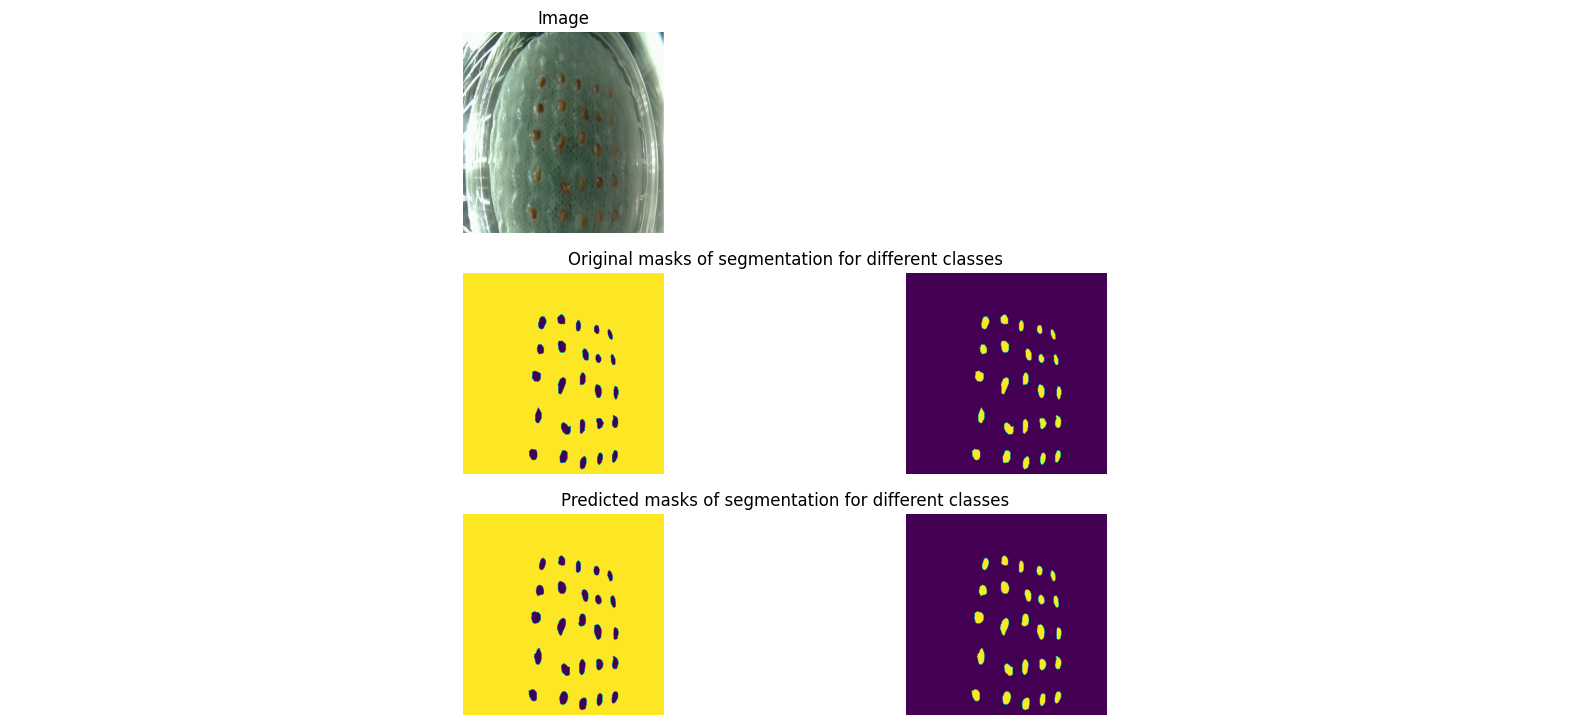

In [21]:
performance_visualization(test_dataset, model, config)

#### **Rendimiento del modelo para datos de evaluación**

In [22]:
import os
import numpy as np
import gc
import tensorflow as tf

def performance_measures(model, dataset, config, save_results=True):

    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Inicializar listas para almacenar los resultados de las métricas
        dice_results = []
        jaccard_results = []
        sensitivity_results = []
        specificity_results = []
        precision_results = []
        recall_results = []
        mAP50_results = []
        mAP50_95_results = []

        # Procesar cada batch en el dataset
        for data_batch in dataset:
            images, masks = data_batch

            # Generar predicciones del modelo
            y_pred = model(images, training=False)
            y_pred_class = y_pred[..., :config['Number of classes']]

            # Calcular métricas
            dice_batch = dice_metric(masks, y_pred_class, return_mean=False)
            jaccard_batch = jaccard_metric(masks, y_pred_class, return_mean=False)
            sensitivity_batch = sensitivity_metric(masks, y_pred_class, return_mean=False)
            specificity_batch = specificity_metric(masks, y_pred_class, return_mean=False)
            precision_batch = precision_metric(masks, y_pred_class, return_mean=False)
            recall_batch = recall_metric(masks, y_pred_class, return_mean=False)
            mAP50_batch = mean_average_precision(masks, y_pred_class, thresholds=[0.5], return_mean=False)
            mAP50_95_batch = mean_average_precision(masks, y_pred_class, thresholds=tf.linspace(0.5, 0.95, 10), return_mean=False)

            # Almacenar resultados en listas
            dice_results.append(dice_batch.numpy().flatten())
            jaccard_results.append(jaccard_batch.numpy().flatten())
            sensitivity_results.append(sensitivity_batch.numpy().flatten())
            specificity_results.append(specificity_batch.numpy().flatten())
            precision_results.append(precision_batch.numpy().flatten())
            recall_results.append(recall_batch.numpy().flatten())
            mAP50_results.append(mAP50_batch.numpy().flatten())
            mAP50_95_results.append(mAP50_95_batch.numpy().flatten())

            # Liberar memoria de variables innecesarias
            del y_pred, y_pred_class, dice_batch, jaccard_batch, sensitivity_batch, specificity_batch
            del precision_batch, recall_batch, mAP50_batch, mAP50_95_batch, images, masks

        # Convertir listas de batches a arrays de NumPy
        dice_results = np.concatenate(dice_results)
        jaccard_results = np.concatenate(jaccard_results)
        sensitivity_results = np.concatenate(sensitivity_results)
        specificity_results = np.concatenate(specificity_results)
        precision_results = np.concatenate(precision_results)
        recall_results = np.concatenate(recall_results)
        mAP50_results = np.concatenate(mAP50_results)
        mAP50_95_results = np.concatenate(mAP50_95_results)

        # Imprimir resumen de métricas
        print("Model's performance metrics:")
        print(f"Dice Coefficient mean: {np.mean(dice_results):.5f}, std: {np.std(dice_results):.5f}")
        print(f"Jaccard Index mean: {np.mean(jaccard_results):.5f}, std: {np.std(jaccard_results):.5f}")
        print(f"Sensitivity mean: {np.mean(sensitivity_results):.5f}, std: {np.std(sensitivity_results):.5f}")
        print(f"Specificity mean: {np.mean(specificity_results):.5f}, std: {np.std(specificity_results):.5f}")
        print(f"Precision mean: {np.mean(precision_results):.5f}, std: {np.std(precision_results):.5f}")
        print(f"Recall mean: {np.mean(recall_results):.5f}, std: {np.std(recall_results):.5f}")
        print(f"mAP@50 mean: {np.mean(mAP50_results):.5f}, std: {np.std(mAP50_results):.5f}")
        print(f"mAP@50-95 mean: {np.mean(mAP50_95_results):.5f}, std: {np.std(mAP50_95_results):.5f}")

        # Guardar resultados en archivos si se solicita
        if save_results:
            if not os.path.exists('./results'):
                os.makedirs('./results')

            filename_base = f"./results/{config['Seg_model']}_{config['Activation']}_{config['Dataset']}"
            np.save(f"{filename_base}_DICE.npy", dice_results)
            np.save(f"{filename_base}_Jaccard.npy", jaccard_results)
            np.save(f"{filename_base}_Sensitivity.npy", sensitivity_results)
            np.save(f"{filename_base}_Specificity.npy", specificity_results)
            np.save(f"{filename_base}_Precision.npy", precision_results)
            np.save(f"{filename_base}_Recall.npy", recall_results)
            np.save(f"{filename_base}_mAP50.npy", mAP50_results)
            np.save(f"{filename_base}_mAP50_95.npy", mAP50_95_results)

        # Liberar memoria
        gc.collect()
        del dice_results, jaccard_results, sensitivity_results, specificity_results
        del precision_results, recall_results, mAP50_results, mAP50_95_results

        return [
            f"{filename_base}_DICE.npy",
            f"{filename_base}_Jaccard.npy",
            f"{filename_base}_Sensitivity.npy",
            f"{filename_base}_Specificity.npy",
            f"{filename_base}_Precision.npy",
            f"{filename_base}_Recall.npy",
            f"{filename_base}_mAP50.npy",
            f"{filename_base}_mAP50_95.npy"
        ]


In [23]:
metrics = performance_measures(model,test_dataset,config,save_results=True)

Model's performance metrics:
Dice Coefficient mean: 0.96416, std: 0.05062
Jaccard Index mean: 0.93500, std: 0.08615
Sensitivity mean: 0.96449, std: 0.05823
Specificity mean: 0.96449, std: 0.05823
Precision mean: 0.96474, std: 0.04778
Recall mean: 0.96449, std: 0.05823
mAP@50 mean: 1.00000, std: 0.00000
mAP@50-95 mean: 0.90297, std: 0.08885
